<div style="background-color:powderblue;"><h1>Projet Synthese</h1><b>Groupe 3: Amardeepkumar Haulkhory, Hilaire Yuma, Jian-Guo Zhao, Mamadou Sy</b></div>

<h2>Partie II Apprentissage par <abbr title="Convolutional Neural Networks"><b>CNN </b></abbr></h2>
<p>Definir le <abbr title="Convolutional Neural Networks"><b>CNN </b></abbr>architecture:</p>
<ol>
<li>La premiere couche, Conv2D, prend un batch de donnees avec input_shape=(48,48,1)</li>
<li>La deuxieme couche, Conv2D, prend la sortie de couche 1, keras determine le shape automatiquement</li>
    <li>Il n'est pas necessaire d'indiquer input_shape pour les couches plus profondes</li>
    <li>La troisieme couche, Conv2D, prend la sortie de la couche 2, keras determine le shape automatiquement</li>
    <li>Ainsi de suite, on peut ajouter autres couches Conv2D s'il y en a besoin</li>
    <li>Entre chaque deux couches Conv2D, une couche Max pooling est ajoutee, pour bonne apprentissage</li>
    <li>Pour reduire le sur-apprentissage, une couche de regularisation Dropout pourrait etre ajoutee</li>
    <li>Pour une meilleur performance, une couche Normalisation pourrait etre aussi appliquee</li>
<li>Avant la couche dense, nous allons ajouter une couche Flatten qui convert le matrix 2D en vector 1D</li>
    <li>Puis, une couche Dense avec une fonction activation ReLu</li>
    <li>Encore une couche de regularization Dropout est appliquee</li>
    <li>Enfin, la couche de sortie donne 7 neurons pour les 7 classes avec une fonction activation softmax qui donne la possibilite de prediction pour chaque class.</li>
</ol>

<h3>Dependences - packages nécessaires</h3>
<p>En utilisant <b>tensorflow.compat.v1</b>, vous devez desactiver eager_execution.<br>Ce n'est pas le cas pour <b>tensorflow.v2</b>. De plus, le package <b>tensorflow</b> n'a pas la fonction <b><i>disable_eager_execution</i></b>.</p>

In [1]:
import tensorflow as tf
#import tensorflow.compat.v1 as tf
#tf.disable_eager_execution()

from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D 
from keras.utils import to_categorical

from keras.utils.data_utils import Sequence
from imblearn.over_sampling import RandomOverSampler
from imblearn.keras import balanced_batch_generator

import numpy as np      # linear algebra
import pandas as pd     # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

import os
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

from numpy import expand_dims
from keras.preprocessing.image import img_to_array

%matplotlib inline

Using TensorFlow backend.


<h3>Chargement des donnees</h3>
<p>Pour eviter l'operation <b>download</b> des donnees se fait chaque fois, on les sauvegarde dans un repertoire local, qui est differente pour different colaborateurs. Veuillez changez la valeur de variable <b><i>data_dir</i></b> si necessaire</p>

In [2]:
data_dir = "C:\\Users\\jeang\\Documents\\BDEB\\A62\\ProSyn3\\data\\fer2013.csv"
df = pd.read_csv(data_dir )

<h3>Repartition des donnees</h3>
<p>Les donnees originales sont repartie en trois partie. Selons Partie I, la cible est bien balance dans ces trois parties</p>

In [3]:
df_training = df[df['Usage']=='Training']
df_PublicTest = df[df['Usage']=='PublicTest']
df_PrivateTest = df[df['Usage']=='PrivateTest']

<h3>Affichage des donnees</h3>
<p> Ces fonctions affichent un image (une ligne)<br>Notons que 48 x 48 = 2304</p>

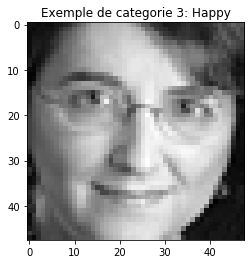

In [4]:
FER2013_WIDTH = 48
FER2013_HEIGHT = 48

# indices 0 - 6 correspondent emotions suivantes
Emotions = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]  

def string_to_image(str_in):
    return np.reshape(str_in.split(" "), (FER2013_WIDTH, FER2013_HEIGHT)).astype("float")

def fer2013_show_instance(index, d=df):
    """Shows the image and the emotion label of the index's instance."""
    category, str_image = d.at[index,'emotion'], d.at[index,'pixels']
    image = string_to_image(str_image)
    plt.imshow(image, cmap="gray")
    plt.title(f"Exemple de categorie {category}: {Emotions[category]}")
    
fer2013_show_instance(np.random.randint(0,len(df_training)))

<h3>Transformation des données</h3>
<p><ul> La fonction <b><i>image_to_4d_array</i></b> prend comme entree une dataframe qui tienne les donnees d'images en format des chaines de caracteres.<br>Elle retoune comme sortie un <b>np.array</b> de <mark>4 dimensions</mark>, normalisee, x, et categoriel y, utilisables comme entree pour <b>tensorflow CNN<b></ul></p>

In [5]:
def image_to_4d_array(d=df):
    """Transforms the (blank separated) pixel strings in the DataFrame to an 4-dimensional array 
    (1st dim: instances, 2nd and 3rd dims represent 2D image, 4th dim represent the color)."""
    
    CLASS_NUMBER = 7
    pixels_list = d["pixels"].values
    list_image_2d = [string_to_image(pixels) for pixels in pixels_list]
        
    # Convert list to 4D array:
    X = np.expand_dims(np.array(list_image_2d), -1)
    X = X / 255  
    Y = to_categorical(d.emotion, CLASS_NUMBER)
    
    print(f"The given dataset has been converted to {X.shape} array")
    
    return X, Y

<p>On applique la fonction <b><i>image_to_4d_array</i></b> sur les trois partitions</P>

In [6]:
X_train, Y_train = image_to_4d_array(df_training)
X_test, Y_test = image_to_4d_array(df_PrivateTest)
X_valid, Y_valid = image_to_4d_array(df_PublicTest)

The given dataset has been converted to (28709, 48, 48, 1) array
The given dataset has been converted to (3589, 48, 48, 1) array
The given dataset has been converted to (3589, 48, 48, 1) array


<h3>Fonction <i>get_model_v23</i></h3>
<p><ul>
<li>Cette fonction <b style="backgroud-color:powerblue"><i>get_model_v23</i></b> peut prendre seulement quelques hyperparametres</li>
<li>Elle appelle <i style="color:blue">keras.models.Sequential</i> qui nous permet de construire un modele cnn</li>
<li>Les valeurs par defaut sont notre choix entre les meilleures, mais elle laisse des chances pour utilisateur de les choisir</li>
<li>Elle retourne un architecture d'un modele Sequential qu'on peut l'entrainner et le tester</li>
</ul></p>

<h4>Points essentiels de la fonction <i>get_model_v23</i></h4>
<p><ol>
<li>Nombre de couche est 5 par defaut, mais elle peut etre un entier de choix</li>
<li>Les nombres de filtre doivent en rapport avec le nombre de couche, preferable plus elevé pour les couches profondes.</li>
<li>Les kenal sizes doivent en rapport avec le nombre de couche, preferable impaire le plus petit que possible</li>
<li>Les pooling size doivent en rapport avec le nombre de couche, preferablement petit ou zero </li>
<li>Les dropout values doivent en rapport avec le nombre de couche, faible quand pas de data augmentation</li>
</ul></p>

In [7]:
def get_model_v23(num_layers=5, lf=128, ld=0.5,
                  num_filtre=(16, 32, 64, 128, 256), 
                  k_size=(3,3,3,3,3), 
                  p_size=(2,2,2,2,0), 
                  dropout=(0.0, 0.0, 0.5, 0.0, 0.0)):
    
    input_shape, num_classes, last_features, last_dropout = (48, 48, 1), 7, lf, ld
    
    model = Sequential()
    
    for layer in range(num_layers): 
        if layer == 0:
            model.add(Conv2D(num_filtre[layer], kernel_size=k_size[layer], activation=tf.nn.relu, padding="same", input_shape=input_shape))
        else:
            model.add(Conv2D(num_filtre[layer], kernel_size=k_size[layer], activation=tf.nn.relu, padding="same"))
            # normalization for each layer but not the first
            model.add(BatchNormalization())
        
        # max pooling with the given choose
        if p_size[layer] > 0:
            model.add(MaxPooling2D(pool_size=(p_size[layer], p_size[layer])))
        
        # Dropout with the given choose
        if dropout[layer] > 0:
            model.add(Dropout(dropout[layer]))           
        

    model.add(Flatten())                          
    model.add(Dense(last_features, activation=tf.nn.relu))
    model.add(Dropout(last_dropout))
    model.add(Dense(num_classes, activation=tf.nn.softmax))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

<h3>Fonction <i>save_model</i></h3>
<p><ul>
<li>Cette fonction <b style="backgroud-color:powerblue"><i>save_model</i></b> prend un Sequential model et nom de fichier</li>
<li>Elle appelle <i style="color:blue">keras.models.Sequential.to_json</i> et save_weights</li>
</ul></p>

In [8]:
def save_model(model, file_json="", file_weight="", workdir=""):
    # serialize model to JSON
    model_json = model.to_json()
    projet_dir = workdir if len(workdir)>0 else "C:\\Users\\jeang\\Documents\\BDEB\\A62\\ProSyn3"
    model_filename = 'fer.json' if file_json=="" else file_json
    with open(os.path.join(projet_dir, model_filename), "w") as json_file:
        json_file.write(model_json)

    # serialize weights to HDF5
    # model.save_weights("C:\\Users\\Nisha Haulkhory\\projet de synthese\\GIT\\ProSyn3\\fer.h5")
    weight_filename = 'fer.h5' if file_weight=="" else file_weight
    model.save_weights(os.path.join(projet_dir, weight_filename))
    print("Model successfully saved to disk.")

<h3>Fonction <i>show_confusion_matrix</i></h3>
<p><ul>
<li>Cette fonction <b style="backgroud-color:powerblue"><i>show_confusion_matrix</i></b> prend comme entree un model</li>
<li>Elle appelle <i style="color:blue">model.predict</i> et le testset pour y_pred</li>
<li>Elle compare y_pred avec les valeurs real pour construire la matrix de confusion</li>
<li>Elle normalize la matrix de confusion car les cibles dans notre donnees originales n'est pas uniforme </li>
</ul></p>

In [9]:
def show_confusion_matrix(model):
    submission = pd.DataFrame(model.predict(X_test))
    submission['label'] = submission.idxmax(axis=1)
    # y_pred = submission['label']
    # y_real = df_PrivateTest['emotion']
    cm = confusion_matrix(submission['label'], df_PrivateTest['emotion'])
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm = cm.round(2)
    return pd.DataFrame(cm)

<h3>Class <i>BalancedDataGenerator</i></h3>
<p><ul>
<li>Cette class <b style="backgroud-color:powerblue"><i>BalancedDataGenerator</i></b> est pour imbalanced dataset</li>
<li>Elle select non uniformement les echantillons pour les agumenter et finir avec relativement uniform dataset</li>
</ul></p>

In [10]:
class BalancedDataGenerator(Sequence):
    """ImageDataGenerator + RandomOversampling"""
    def __init__(self, x, y, datagen, batch_size=256):
        self.datagen = datagen
        self.batch_size = min(batch_size, x.shape[0])
        datagen.fit(x)
        self.gen, self.steps_per_epoch = balanced_batch_generator(x.reshape(x.shape[0], -1), y, 
                                                                  sampler=RandomOverSampler(), 
                                                                  batch_size=self.batch_size, keep_sparse=True)
        self._shape = (self.steps_per_epoch * batch_size, *x.shape[1:])
        
    def __len__(self):
        return self.steps_per_epoch

    def __getitem__(self, idx):
        x_batch, y_batch = self.gen.__next__()
        x_batch = x_batch.reshape(-1, *self._shape[1:])
        return self.datagen.flow(x_batch, y_batch, batch_size=self.batch_size).next()

<h3>Objet <i>ImageDataGenerator</i></h3>
<p><ul>
<li>Cette instance d'objet <b style="backgroud-color:powerblue"><i>datagen</i></b> est utilisable dans plusieurs cas pour data augmentation</li>
</ul></p>

In [11]:
datagen = ImageDataGenerator(featurewise_center=False,
                             featurewise_std_normalization=False,
                             rotation_range=45,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             shear_range=0.2,
                             zoom_range=.2,
                             horizontal_flip=True,
                             vertical_flip=True)

# bgen = BalancedDataGenerator(X_train, Y_train, datagen, batch_size=256)
# steps_per_epoch = bgen.steps_per_epoch

<h3>Fonction <i>fit_test_save_model</i></h3>
<p><ul>
<li>Cette fonction <b style="backgroud-color:powerblue"><i>fit_test_save_model</i></b> regroupe plusieurs commandes</li>
<li>Elle fournie une interface pour l'apprentissage, evaluation, visualisation, et sauvegarde du model cnn</li>
<li>Si le drapeau <b style="backgroud-color:powerblue"><i>aug</i></b> est False, elle apprend le model avec trainset et validation set</li>
<li>Si le drapeau <b style="backgroud-color:powerblue"><i>aug</i></b> est True, elle apprend le model avec augmented trainset</li>
<li>Une fois l'apprentissage se termine, elle execute des commandes pour display l'histoire d'apprentissage, sauvegarder le model etc</li>
</ul></p>

In [12]:
def fit_test_save_model(model, x_train=X_train, y_train=Y_train, valid=(X_valid, Y_valid), 
                        aug=True, imbalance=False, dgen = datagen,
                        bs=128, ep=30, fnm='fer.json', fnw='fer.h5'):
    
    print("Fitting the model ...")
    batch_size = min(bs, x_train.shape[0])
    
    if not aug:
        l = model.fit(x=x_train, y=y_train, validation_data=valid, batch_size=batch_size, epochs=ep)
    elif imbalance:
        bgen = BalancedDataGenerator(x_train, y_train, dgen, batch_size=batch_size)
        steps_per_epoch = bgen.steps_per_epoch
        l = model.fit_generator(bgen, steps_per_epoch, epochs=ep, validation_data=valid, verbose = 1)
    else:
        l = model.fit_generator(dgen.flow(x_train, y_train, batch_size=batch_size), epochs=ep, validation_data=valid,
                                verbose = 1, steps_per_epoch = x_train.shape[0] / 100,)
        
    sns.lineplot(data=pd.DataFrame(l.history)[['accuracy','val_accuracy']], palette="tab10", linewidth=2.5);
    save_model(model, file_json=fnm, file_weight=fnw)
    print("Evaluating the model on test data ...")
    results = model.evaluate(X_test, Y_test)
    print("test loss, test acc:", results)
    print(show_confusion_matrix(model))
    return l, results

<h3>1er exemple de construire un CNN model</h3>
<p>Par defaut, il y a 5 couches, la taille ksize est (3,3) pour chaque couche</p>
<p>Notons que les valeurs dropout sont 0 pour les 5 couches, mais last_dropout(ld) est 0.35</p>

In [13]:
model = get_model_v23(num_filtre=(16, 32, 64, 128, 256), lf=256, ld=0.35, p_size=(2,2,2,2,0), dropout=(0.0, 0.0, 0.0, 0.0, 0.0))

<h3>1er Exemple d'apprentissage un CNN model</h3>
<p>Par defaut, il utilise technique de data augmentation uniformement sur tous les echantillons</p>

Fitting the model ...
Epoch 1/50
288/287 [==============================] - 123s 426ms/step - loss: 1.8257 - accuracy: 0.2487 - val_loss: 2.1456 - val_accuracy: 0.2232
Epoch 2/50
288/287 [==============================] - 117s 406ms/step - loss: 1.7691 - accuracy: 0.2715 - val_loss: 1.7515 - val_accuracy: 0.2669
Epoch 3/50
288/287 [==============================] - 119s 413ms/step - loss: 1.7100 - accuracy: 0.3082 - val_loss: 1.6581 - val_accuracy: 0.3488
Epoch 4/50
288/287 [==============================] - 119s 415ms/step - loss: 1.6275 - accuracy: 0.3585 - val_loss: 1.7609 - val_accuracy: 0.3235
Epoch 5/50
288/287 [==============================] - 118s 409ms/step - loss: 1.5560 - accuracy: 0.3961 - val_loss: 1.5712 - val_accuracy: 0.4026
Epoch 6/50
288/287 [==============================] - 115s 401ms/step - loss: 1.5067 - accuracy: 0.4182 - val_loss: 1.3816 - val_accuracy: 0.4687
Epoch 7/50
288/287 [==============================] - 114s 397ms/step - loss: 1.4665 - accuracy: 0.435

NameError: name 'submission' is not defined

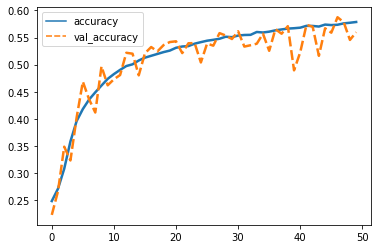

In [14]:
l,r = fit_test_save_model(model, bs=256, ep=50, fnm='fer231.json', fnw='fer231.h5')

In [16]:
show_confusion_matrix(model)

,0,1,2,3,4,5,6
0,0.45,0.06,0.18,0.09,0.13,0.04,0.05
1,0.00,0.62,0.12,0.00,0.25,0.00,0.00
2,0.14,0.01,0.39,0.07,0.15,0.15,0.08
3,0.02,0.00,0.04,0.80,0.05,0.03,0.05
4,0.16,0.02,0.19,0.03,0.42,0.02,0.17
5,0.04,0.01,0.17,0.04,0.03,0.64,0.07
6,0.13,0.00,0.09,0.07,0.20,0.01,0.50


<h3>2eme exemple de construire un CNN model</h3>
<p>Par defaut, il y a 5 couches, la taille ksize est (3,3) pour chaque couche</p>
<p>Notons que les valeurs dropout sont 0.2 ou 0.25 pour les 5 couches, et last_dropout(ld) est 0.5</p>

In [13]:
model = get_model_v23(num_filtre=(16, 32, 64, 128, 256), lf=256, ld=0.5, p_size=(2,2,2,2,0), dropout=(0.20, 0.20, 0.25, 0.20, 0.20))

<h3>2eme Exemple d'apprentissage un CNN model</h3>
<p>Cette fois, il n'utilise pas de technique de data augmentation</p>

Fitting the model ...
Train on 28709 samples, validate on 3589 samples
Epoch 1/50
28709/28709 [==============================] - 51s 2ms/step - loss: 1.8900 - accuracy: 0.2353 - val_loss: 2.0775 - val_accuracy: 0.2494
Epoch 2/50
28709/28709 [==============================] - 50s 2ms/step - loss: 1.7935 - accuracy: 0.2590 - val_loss: 1.9904 - val_accuracy: 0.1694
Epoch 3/50
28709/28709 [==============================] - 51s 2ms/step - loss: 1.7477 - accuracy: 0.2901 - val_loss: 1.8258 - val_accuracy: 0.2722
Epoch 4/50
28709/28709 [==============================] - 49s 2ms/step - loss: 1.6806 - accuracy: 0.3326 - val_loss: 1.7297 - val_accuracy: 0.3037
Epoch 5/50
28709/28709 [==============================] - 49s 2ms/step - loss: 1.6156 - accuracy: 0.3653 - val_loss: 1.5674 - val_accuracy: 0.3940
Epoch 6/50
28709/28709 [==============================] - 49s 2ms/step - loss: 1.5540 - accuracy: 0.3989 - val_loss: 1.4715 - val_accuracy: 0.4227
Epoch 7/50
28709/28709 [=======================

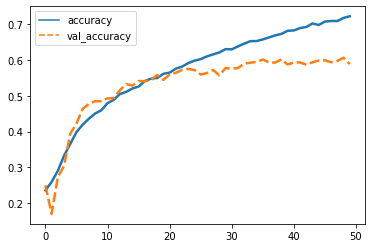

In [14]:
l,r = fit_test_save_model(model, bs=256, ep=50, aug=False, fnm='fer232.json', fnw='fer232.h5')

<h3>3eme exemple de construire un CNN model</h3>
<p>Par defaut, il y a 5 couches, la taille k_size est (3,3) pour chaque couche</p>
<p>Notons que les valeurs dropout sont 0 pour les 5 couches, mais last_dropout(ld) est 0.35</p>

In [15]:
model = get_model_v23(num_filtre=(16, 32, 64, 128, 256), lf=256, ld=0.35, p_size=(2,2,2,2,0), dropout=(0.0, 0.0, 0.0, 0.0, 0.0))

<h3>3eme Exemple d'apprentissage un CNN model</h3>
<p>Cette fois, il utilise technique de imbalanced data augmentation</p>

Fitting the model ...


C:\Users\jeang\anaconda3\envs\rl_env\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass classes=[0 1 2 3 4 5 6] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Epoch 1/50
197/197 [==============================] - 79s 403ms/step - loss: 1.9623 - accuracy: 0.1813 - val_loss: 2.2761 - val_accuracy: 0.0162
Epoch 2/50
197/197 [==============================] - 79s 399ms/step - loss: 1.9119 - accuracy: 0.1967 - val_loss: 2.4423 - val_accuracy: 0.0156
Epoch 3/50
197/197 [==============================] - 78s 394ms/step - loss: 1.8896 - accuracy: 0.2160 - val_loss: 2.1790 - val_accuracy: 0.0688
Epoch 4/50
197/197 [==============================] - 79s 399ms/step - loss: 1.8464 - accuracy: 0.2446 - val_loss: 1.9859 - val_accuracy: 0.1480
Epoch 5/50
197/197 [==============================] - 78s 395ms/step - loss: 1.8024 - accuracy: 0.2682 - val_loss: 1.8463 - val_accuracy: 0.2385
Epoch 6/50
197/197 [==============================] - 78s 394ms/step - loss: 1.7614 - accuracy: 0.2909 - val_loss: 1.7264 - val_accuracy: 0.2828
Epoch 7/50
197/197 [==============================] - 78s 395ms/step - loss: 1.7179 - accuracy: 0.3186 - val_loss: 1.6008 - val_ac

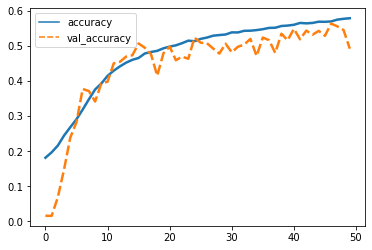

In [17]:
l,r = fit_test_save_model(model, bs=256, ep=50, imbalance=True, fnm='fer233.json', fnw='fer233.h5')

<h3>Autre Exemple d'apprentissage un CNN model</h3>
<p>Cette fois, on entrainne le meme model en souhaitant le overfitting est bien controle</p>

Fitting the model ...


C:\Users\jeang\anaconda3\envs\rl_env\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass classes=[0 1 2 3 4 5 6] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Epoch 1/20
197/197 [==============================] - 81s 410ms/step - loss: 1.1208 - accuracy: 0.5747 - val_loss: 1.1795 - val_accuracy: 0.5578
Epoch 2/20
197/197 [==============================] - 84s 428ms/step - loss: 1.1194 - accuracy: 0.5760 - val_loss: 1.2240 - val_accuracy: 0.5436
Epoch 3/20
197/197 [==============================] - 84s 426ms/step - loss: 1.1188 - accuracy: 0.5762 - val_loss: 1.2230 - val_accuracy: 0.5327
Epoch 4/20
197/197 [==============================] - 89s 449ms/step - loss: 1.1140 - accuracy: 0.5807 - val_loss: 1.1737 - val_accuracy: 0.5561
Epoch 5/20
197/197 [==============================] - 86s 438ms/step - loss: 1.1022 - accuracy: 0.5817 - val_loss: 1.3114 - val_accuracy: 0.5205
Epoch 6/20
197/197 [==============================] - 80s 404ms/step - loss: 1.1014 - accuracy: 0.5842 - val_loss: 1.3433 - val_accuracy: 0.4957
Epoch 7/20
197/197 [==============================] - 82s 414ms/step - loss: 1.1004 - accuracy: 0.5827 - val_loss: 1.2527 - val_ac

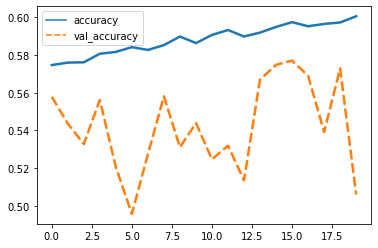

In [18]:
l,r = fit_test_save_model(model, bs=256, ep=20, imbalance=True, fnm='fer234.json', fnw='fer234.h5')

<h2>Conclusion</h2>
<p><ul>
<li>L'interface de construire du model et l'apprentissage se font par deux fonctions simplement</li>
<li>Sans data augmentation, l'accuracy maximum obtenue sur testset est 61%</li>
<li>Avec data augmentation, on attend de meilleurs accuracy, mais ce n'est pas notre cas</li>
<li>Nous devons verifier si les donnees sont en format demande par les techniques de data augmentation</li>
</ul></p>